In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL.feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL.feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL.feedback.processors.linear_transform import Averager
from PyHEADTAIL.feedback.processors.misc import Bypass
from PyHEADTAIL.feedback.processors.register import Register

np.random.seed(0)

PyHEADTAIL v1.13.0.17
(dirty git work tree)


--> Use the longitudinal_tracking module instead.

PyHEADTAIL_feedback v0.2




/home/lmether/Desktop/PyHEADTAIL_multibunch_merge/PyHEADTAIL_develop/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


# 003 Multiple pickups and kickers

In this test/example, multiple pickups and kickers are included into the simulation. 

## Basic parameters and elements for the simulations

In [2]:
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3
# n_sigma_z = 6

n_turns = 50

# Longitudinal motion of the bunch is not taken into account by default, but it can be included by uncommenting
# the line below
machine = Machine(n_segments= n_segments)
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles, n_slices,n_sigma_z)

*** I am rank 0 - my buckets are [0]


## Initial bunch kick
Creates an artificially (slice-by-slice) kicked bunch, which will be damped by using different feedback systems. 

In [3]:
slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# Random slice kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

# A bunch kick
# kick_x = 0.003*np.ones(n_slices)
# kick_y = 0.003*np.ones(n_slices)

## Feedback settings

In [4]:
feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

# delay (a number of turns) before the pickup signal is used to the correction kick calculations.
delay = 1

# a number of values used to calculate the correct signal
n_values = 2

## Reference data
Tracks a bunch by using an ideal bunch-by-bunch feedback system presented in the previous test (001_ideal_feedbacks.ipynb). This data are used as a reference data for the feedback model including multiple pickups and kickers. Note that the gain value is doubled to the reference data because two kickers are used in the actual simulation.

In [5]:
bunch_ref_data = copy.deepcopy(bunch_ref)
tracker_ref_data = BunchTracker(bunch_ref_data)
slicer_ref_data = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

feedback_map = OneboxFeedback(2.*feedback_gain,slicer_ref_data,processors_bunch_x,processors_bunch_y)
one_turn_map = [i for i in trans_map] + [feedback_map] #  + [long_map]

track(n_turns, bunch_ref_data,one_turn_map ,tracker_ref_data)

## Multiple pickups and kickers
In this test, three pickups and two kickers are used in the one turn map. The first kicker uses signals from the pickup 1 and the pickup 2 and the second kicker uses signals from the pickup 1 and the pickup 3.


In [6]:
bunch_multi_object = copy.deepcopy(bunch_ref)
tracker_multi_object = BunchTracker(bunch_multi_object)
slicer_multi_object = copy.deepcopy(slicer_ref)

### Pickups
Pickups are created in the same way as in the previous test *(002\_single\_bunch\_\-\_separate\_pickup\_and\_kicker.ipynb)*.

In [7]:
# Pickup 1
# --------
pickup1_beta_x = machine.beta_x
pickup1_beta_y = machine.beta_y
pickup1_location_x = 1.*2.*pi/float(n_segments)*machine.Q_x
pickup1_location_y = 1.*2.*pi/float(n_segments)*machine.Q_y

pickup1_processors_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
pickup1_processors_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup1_map = PickUp(slicer_multi_object,
                     pickup1_processors_x,pickup1_processors_y, 
                     pickup1_location_x, pickup1_beta_x,
                     pickup1_location_y, pickup1_beta_y)

# Pickup 2
# --------
pickup2_beta_x = machine.beta_x
pickup2_beta_y = machine.beta_y
pickup2_location_x = 2.*2.*pi/float(n_segments)*machine.Q_x
pickup2_location_y = 2.*2.*pi/float(n_segments)*machine.Q_y

pickup2_processors_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
pickup2_processors_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup2_map = PickUp(slicer_multi_object,
                     pickup2_processors_x,pickup2_processors_y, 
                     pickup2_location_x, pickup2_beta_x,
                     pickup2_location_y, pickup2_beta_y)

# Pickup 3
# --------
pickup3_beta_x = machine.beta_x
pickup3_beta_y = machine.beta_y
pickup3_location_x = 3.*2.*pi/float(n_segments)*machine.Q_x
pickup3_location_y = 3.*2.*pi/float(n_segments)*machine.Q_y

pickup3_processors_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
pickup3_processors_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup3_map = PickUp(slicer_multi_object,
                     pickup3_processors_x, pickup3_processors_y, 
                     pickup3_location_x, pickup3_beta_x,
                     pickup3_location_y, pickup3_beta_y)

### Kickers

Also, kickers are created in the same way as in the previous test *(002\_single\_bunch\_\-\_separate\_pickup\_and\_kicker.ipynb)*. The only difference is that the kickers use signals from multiple registers. The registers from the pickup 1 and the pickup 2 are added into the kicker 1 register list and the registers from the pickup 1 and the pickup 3 are added into the kicker 2 register list.

In [8]:
# Kicker 1
# --------
kicker1_processors_x = [Bypass()]
kicker1_processors_y = [Bypass()]

kicker1_beta_x = machine.beta_x
kicker1_beta_y = machine.beta_y
kicker1_location_x = 2.*2.*pi/float(n_segments)*machine.Q_x
kicker1_location_y = 2.*2.*pi/float(n_segments)*machine.Q_y

# kicker 1 uses signals from the pickup 1 and the pickup 2
kicker1_registers_x = [
    pickup1_processors_x[-1],
    pickup2_processors_x[-1]
]
kicker1_registers_y = [
    pickup1_processors_y[-1],
    pickup2_processors_y[-1]
]

kicker1_map = Kicker(feedback_gain, slicer_multi_object, 
                     kicker1_processors_x, kicker1_processors_y,
                     kicker1_registers_x, kicker1_registers_y,
                     kicker1_location_x, kicker1_beta_x,
                     kicker1_location_y, kicker1_beta_y)

# Kicker 2
# --------
kicker2_processors_x = [Bypass()]
kicker2_processors_y = [Bypass()]

kicker2_beta_x = machine.beta_x
kicker2_beta_y = machine.beta_y
kicker2_location_x = 4.*2.*pi/float(n_segments)*machine.Q_x
kicker2_location_y = 4.*2.*pi/float(n_segments)*machine.Q_y

# kicker 2 uses signals from the pickup 1 and the pickup 3
kicker2_registers_x = [
    pickup1_processors_x[-1],
    pickup3_processors_x[-1]
]
kicker2_registers_y = [
    pickup1_processors_y[-1],
    pickup3_processors_y[-1]
]

kicker2_map = Kicker(feedback_gain, slicer_multi_object, 
                     kicker2_processors_x, kicker2_processors_y,
                     kicker2_registers_x, kicker2_registers_y,
                     kicker2_location_x, kicker2_beta_x,
                     kicker2_location_y, kicker2_beta_y)

### One turn map and tracking
The pickup and kicker objects must be added to the correct slots in the one turn map. In this test, it was chosen that the pickup locations are after the 1st, 2nd and 3rd transverse elements and the kickers after the 2nd and the 4th transverse elements.

In [9]:
one_turn_map = [trans_map[0]] + [pickup1_map] + [trans_map[1]] + [pickup2_map] + [kicker1_map] + [trans_map[2]]+ [pickup3_map] + [trans_map[3]] + [kicker2_map]
for element in trans_map[4:]:
    one_turn_map += [element]
# one_turn_map += [long_map]
    
track(n_turns, bunch_multi_object,one_turn_map,tracker_multi_object)

## Results comparison

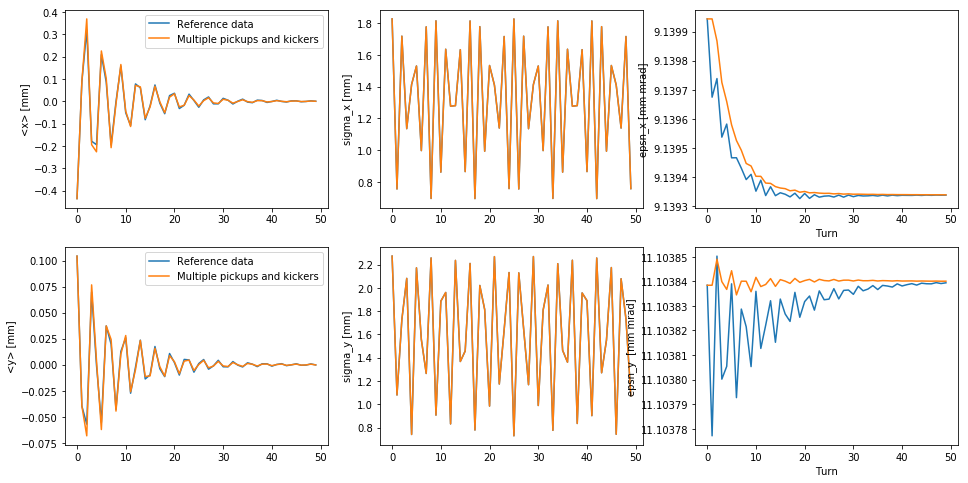

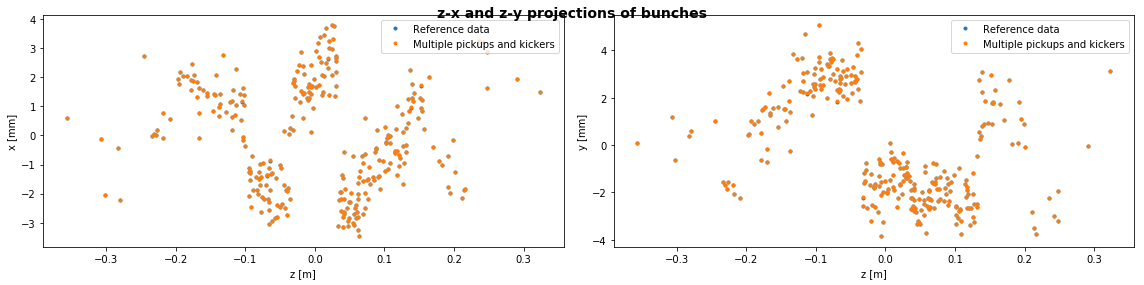

In [10]:
# In here, the traces and the projections from different implementations of the feedback system are compared.
# Note the scale in the emittance figures.

compare_traces([tracker_ref_data,tracker_multi_object],
               ['Reference data', 'Multiple pickups and kickers'])
compare_projections([ bunch_ref_data,  bunch_multi_object], 
                    ['Reference data', 'Multiple pickups and kickers'])

Jani Komppula, CERN, 2017